In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Loading the Dataset

In [2]:
df = pd.read_csv('starcraft_player_data.csv', sep=',')
df = df.dropna()
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


# Checking the Data for null values

In [3]:
df.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

## Checking the column for unique values and looking for columns with 0 values

In [4]:
for col in df.columns:
  #print('--------------------------------------------------','\n')
  print(col,'\n')
  print(df[col].value_counts(),'\n')
  print('--------------------------------------------------','\n')

GameID 

52       1
6345     1
6351     1
6352     1
6358     1
        ..
3256     1
3257     1
3258     1
3261     1
10095    1
Name: GameID, Length: 3395, dtype: int64 

-------------------------------------------------- 

LeagueIndex 

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64 

-------------------------------------------------- 

Age 

20    357
21    344
18    325
22    314
19    313
23    259
16    256
17    248
24    225
25    168
26    136
27    111
28     73
?      55
29     52
30     32
31     29
32     21
35     17
33     15
34     15
36      8
38      5
37      5
40      4
41      3
39      3
43      1
44      1
Name: Age, dtype: int64 

-------------------------------------------------- 

HoursPerWeek 

10     411
8      390
20     335
12     331
6      323
28     280
24     233
16     223
4      219
14     181
2      108
42      92
?       56
30      54
36      50
56      33
18      24
40      12
70       9
48

## Visualizing the above findings to graphically see how many 0 values are there and whats the overall distribution of values and the nature of the data in these columns.

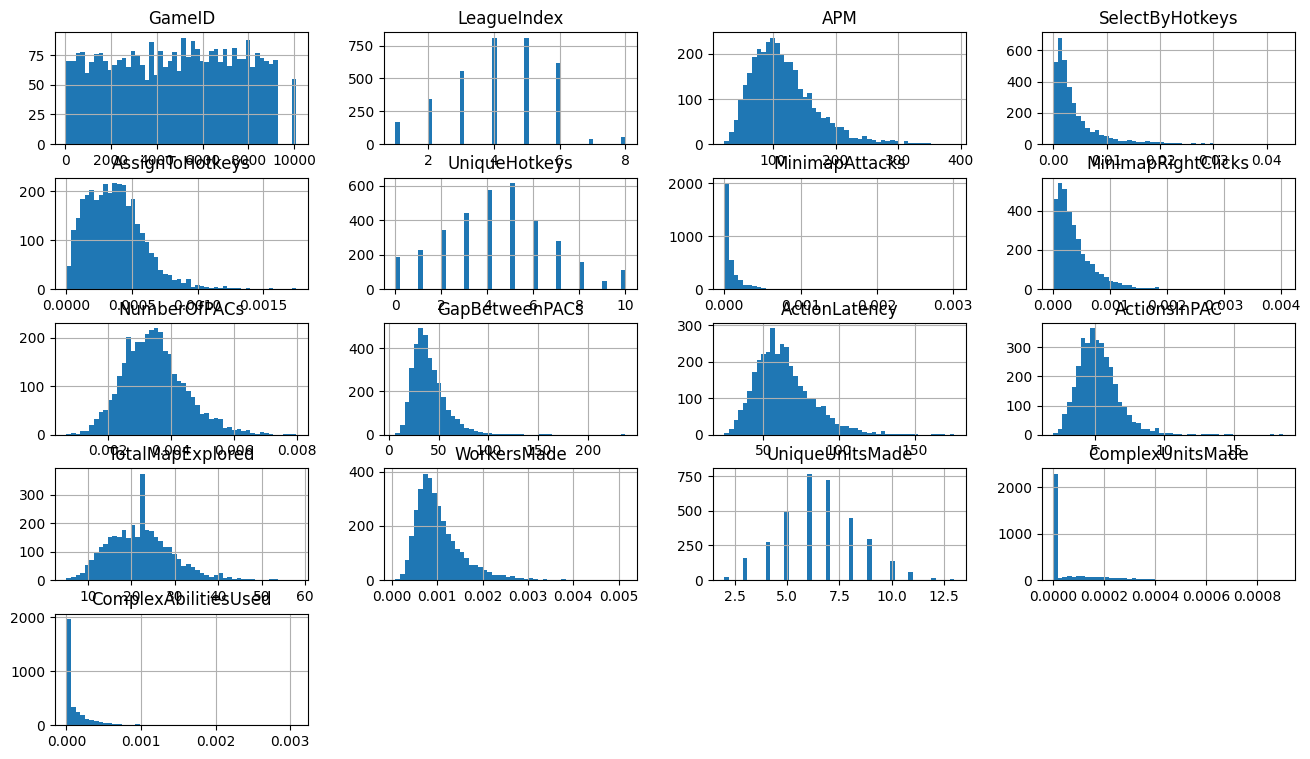

In [5]:
# Check the distributions of the data
df.hist(figsize=(16, 9), bins=50)
plt.show()

## Checking missing values percentage for columns with '?'

In [6]:
## Checking missing Values
for col in df.columns:
  if '?' in df[col].unique():
    print('-----------------------------------------------------------')
    print("Percentage of missing values in: ",col,'\n')
    print(len(df.loc[df[col]=='?'])/len(df)*100,'\n')

-----------------------------------------------------------
Percentage of missing values in:  Age 

1.6200294550810017 

-----------------------------------------------------------
Percentage of missing values in:  HoursPerWeek 

1.6494845360824744 

-----------------------------------------------------------
Percentage of missing values in:  TotalHours 

1.678939617083947 



/var/folders/c6/fb3mz9qj1yj8kq2g4rknl4rw0000gn/T/ipykernel_59310/911768668.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '?' in df[col].unique():


### Cleaning the data to remove values '?' and some outliers which may be errors in data collection. Also converting the datatypes to int for 'TotalHours' and 'HoursPerWeek' column

In [7]:
df = df[df['TotalHours'] != 1000000]
df = df[df['TotalHours'] != '?']
df = df[df['Age'] != '?']
df = df[df['HoursPerWeek'] != '?']
df['Age'] = df['Age'].astype(int)
df['TotalHours'] = df['TotalHours'].astype(int)
df['HoursPerWeek'] = df['HoursPerWeek'].astype(int)

In [ ]:
### Finding the correlation of columns with each other

In [8]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df.corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,1.000000,0.024974,0.088511,-0.025322,0.004178,0.075944,0.070298,0.063915,0.081176,0.022422,0.009898,0.035622,-0.065629,-0.042711,0.039482,0.030894,-0.015191,0.029487,-0.018056,0.004051
LeagueIndex,0.024974,1.000000,-0.127518,0.217930,0.023884,0.624171,0.428637,0.487280,0.322415,0.270526,0.206380,0.589193,-0.537536,-0.659940,0.140303,0.230347,0.310452,0.151933,0.171190,0.156033
Age,0.088511,-0.127518,1.000000,-0.184431,-0.016630,-0.210724,-0.131105,-0.104960,0.015119,0.043100,-0.019904,-0.197128,0.112106,0.240240,-0.045893,-0.024191,-0.092291,0.022893,-0.080269,-0.065603
HoursPerWeek,-0.025322,0.217930,-0.184431,1.000000,0.024306,0.246897,0.205792,0.158316,0.070262,0.084103,0.049498,0.174871,-0.133838,-0.188735,0.095271,0.064896,0.050679,0.038524,0.059285,0.074713
TotalHours,0.004178,0.023884,-0.016630,0.024306,1.000000,0.072850,0.081830,0.042415,0.009318,0.000869,0.007662,0.039577,-0.020644,-0.035700,0.010704,0.020486,0.014828,-0.002379,-0.007154,-0.006311
APM,0.075944,0.624171,-0.210724,0.246897,0.072850,1.000000,0.814624,0.534134,0.335986,0.218562,0.306392,0.635248,-0.567396,-0.722253,0.402928,0.239336,0.377719,0.122916,0.161774,0.141060
SelectByHotkeys,0.070298,0.428637,-0.131105,0.205792,0.081830,0.814624,1.000000,0.450342,0.274030,0.132723,0.107615,0.360057,-0.273767,-0.390012,0.166964,0.097397,0.161404,0.027628,0.065467,0.063720
AssignToHotkeys,0.063915,0.487280,-0.104960,0.158316,0.042415,0.534134,0.450342,1.000000,0.402555,0.205436,0.154998,0.454480,-0.377926,-0.461496,0.091508,0.201862,0.197011,0.149329,0.169849,0.169048
UniqueHotkeys,0.081176,0.322415,0.015119,0.070262,0.009318,0.335986,0.274030,0.402555,1.000000,0.151029,0.124570,0.353112,-0.223745,-0.304583,-0.022227,0.267940,0.111319,0.233274,0.122352,0.110004
MinimapAttacks,0.022422,0.270526,0.043100,0.084103,0.000869,0.218562,0.132723,0.205436,0.151029,1.000000,0.224683,0.137745,-0.213330,-0.171464,0.133712,0.164110,0.082283,0.125035,0.052225,0.042265


###  Removing columns with high correlation to remove mutual affect on the final rank prediction and creating a filtered data frame

In [9]:
import pandas as pd


# Set the threshold value
threshold = 0.8

# Find column pairs with correlation above the threshold
correlated_columns = []
for i in range(len(table.columns)):
    for j in range(i + 1, len(table.columns)):
        if abs(table.iloc[i, j]) > threshold:
            correlated_columns.append((table.columns[i], table.columns[j]))

# Print the correlated columns
print("Correlated columns:")
for col1, col2 in correlated_columns:
    print(f"{col1} and {col2}")

# Remove columns with correlation above the threshold
columns_to_remove = set()
for col1, col2 in correlated_columns:
    if col1 in columns_to_remove or col2 in columns_to_remove:
        continue
    columns_to_remove.add(col2)

df_filtered = df.drop(columns=columns_to_remove)

# Print the filtered DataFrame
print("\nFiltered DataFrame:")
print(df_filtered)

Correlated columns:
APM and SelectByHotkeys
NumberOfPACs and ActionLatency

Filtered DataFrame:
      GameID  LeagueIndex  Age  HoursPerWeek  TotalHours       APM  \
0         52            5   27            10        3000  143.7180   
1         55            5   23            10        5000  129.2322   
2         56            4   30            10         200   69.9612   
3         57            3   19            20         400  107.6016   
4         58            3   32            10         500  122.8908   
...      ...          ...  ...           ...         ...       ...   
3335    9261            4   20             8         400  158.1390   
3336    9264            5   16            56        1500  186.1320   
3337    9265            4   21             8         100  121.6992   
3338    9270            3   20            28         400  134.2848   
3339    9271            4   22             6         400   88.8246   

      AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRi

### Identified NumberOfPACs as our column to be the dependent variable and the rest to be the explanatory variables based on the values obtained from correlation table generated above and the distribution of values in that column which makes it more suitable for our model. Based on the data available players in higher leagues tend to have higher 'NumberOfPACs' which made it a good measure of a players ability to succeed in a league.
### Running Linear Regression on 'NumberOfPACs' identify statistically significant columns for predicting 'NumberOfPACs'

In [10]:
import statsmodels.api as sm



# Define the predictor and target variables
X = df_filtered.drop(['GameID', 'NumberOfPACs'], axis=1)
y = df_filtered['NumberOfPACs']

# Add a constant column to the predictor variables
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           NumberOfPACs   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     843.4
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        14:16:32   Log-Likelihood:                 21146.
No. Observations:                3338   AIC:                        -4.226e+04
Df Residuals:                    3321   BIC:                        -4.215e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0037 

### Running Linear Regression on 'NumberOfPACs' and removing statistically insignificant columns identified on the basis of p-value obtained in the Linear Regression results as shown above

In [14]:

# Define the predictor and target variables
X = df_filtered.drop(['GameID', 'AssignToHotkeys','NumberOfPACs'], axis=1)
y = df_filtered['NumberOfPACs']

# Add a constant column to the predictor variables
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           NumberOfPACs   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     899.9
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        14:17:49   Log-Likelihood:                 21146.
No. Observations:                3338   AIC:                        -4.226e+04
Df Residuals:                    3322   BIC:                        -4.216e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0037 

### Running Linear Regression on 'NumberOfPACs' and further removing statistically insignificant columns such as 'AssignToHotkeys','NumberOfPACs', 'TotalHours', 'Age','WorkersMade','ComplexUnitsMade' ,identified on the basis of p-value obtained in the Linear Regression results as shown above

In [13]:
# Define the predictor and target variables
X = df_filtered.drop(['GameID', 'AssignToHotkeys','NumberOfPACs', 'TotalHours', 'Age','WorkersMade','ComplexUnitsMade' ], axis=1)
y = df_filtered['NumberOfPACs']

# Add a constant column to the predictor variables
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           NumberOfPACs   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1168.
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        14:17:46   Log-Likelihood:                 21079.
No. Observations:                3338   AIC:                        -4.213e+04
Df Residuals:                    3326   BIC:                        -4.206e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0035 

### Predicting 'NumberOfPACs' value after dropping all the insignificant columns from the dataset and scaling the data using a standard scaler to account for the different scales of values in each column. For e.g APM ranges in 20-300 while 'NumberOfPACs' ranges between 0 to 0.008

In [64]:
X = df_filtered.drop(['GameID', 'AssignToHotkeys','NumberOfPACs', 'TotalHours', 'Age','WorkersMade','ComplexUnitsMade'], axis=1)  # features
y = df_filtered['NumberOfPACs']  # target variable

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Feature selection using Recursive Feature Elimination
model = LinearRegression()


# Train the model on the training data
model.fit(X_train, y_train)



# Make predictions on the test data
y_pred = model.predict(X_test)

# Print the performance of the model
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  1.8744757205830727e-07
R2 Score:  0.7891815587345546


In [49]:
type(X_test)

numpy.ndarray

### Merging the predicted 'NumberOfPACs' values with the X_test dataset after unscaling it.

In [67]:
y_pred = pd.Series(y_pred )
scaler = StandardScaler()
scaler.fit(X)  # Fit the scaler on the original unscaled data

X_test = scaler.inverse_transform(X_test)
X_test = pd.DataFrame(X_test,columns = X.columns)
merged_df = pd.concat([X_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
merged_df = merged_df.rename(columns={0: 'NumberOfPACs'})
merged_df.head()

,LeagueIndex,HoursPerWeek,APM,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,GapBetweenPACs,ActionsInPAC,TotalMapExplored,UniqueUnitsMade,ComplexAbilitiesUsed,NumberOfPACs
0,4.0,20.0,75.2070,6.0,0.000000,0.000680,49.7117,4.3094,22.0,7.0,0.000057,0.003211
1,4.0,4.0,95.2848,2.0,0.000029,0.000262,12.0435,5.9462,15.0,5.0,0.000000,0.003152
2,3.0,14.0,106.6950,4.0,0.000000,0.000095,69.0196,5.0670,23.0,8.0,0.000000,0.002985
3,3.0,30.0,155.9970,8.0,0.000000,0.000574,31.4647,7.6895,28.0,10.0,0.002664,0.003521
4,3.0,20.0,77.5146,5.0,0.000049,0.000450,34.6066,4.4245,15.0,5.0,0.000061,0.003099


### Creating a column Rank where I am grouping the players in a league and assigning them ranks in descending order based on their 'NumberOfPACs' value considering higher the value, better the player and this can be verified by the correlation heatmap given above as it has a positive correlation with LeagueIndex. The assumption being better players are placed in higher leagues as suggested by the data dictionary given with the dataset.

In [69]:
merged_df['Rank'] = merged_df.groupby('LeagueIndex')['NumberOfPACs'].rank(ascending=False, method='min')
merged_df.head()

,LeagueIndex,HoursPerWeek,APM,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,GapBetweenPACs,ActionsInPAC,TotalMapExplored,UniqueUnitsMade,ComplexAbilitiesUsed,NumberOfPACs,Rank
0,4.0,20.0,75.2070,6.0,0.000000,0.000680,49.7117,4.3094,22.0,7.0,0.000057,0.003211,139.0
1,4.0,4.0,95.2848,2.0,0.000029,0.000262,12.0435,5.9462,15.0,5.0,0.000000,0.003152,152.0
2,3.0,14.0,106.6950,4.0,0.000000,0.000095,69.0196,5.0670,23.0,8.0,0.000000,0.002985,79.0
3,3.0,30.0,155.9970,8.0,0.000000,0.000574,31.4647,7.6895,28.0,10.0,0.002664,0.003521,20.0
4,3.0,20.0,77.5146,5.0,0.000049,0.000450,34.6066,4.4245,15.0,5.0,0.000061,0.003099,61.0


In [71]:
sorted_df = merged_df.sort_values(by='Rank', ascending=True)
sorted_df.head(20)

,LeagueIndex,HoursPerWeek,APM,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,GapBetweenPACs,ActionsInPAC,TotalMapExplored,UniqueUnitsMade,ComplexAbilitiesUsed,NumberOfPACs,Rank
722,1.0,28.0,70.5282,1.0,0.000000,0.000036,49.5268,3.4780,44.0,5.0,0.000012,0.003625,1.0
129,5.0,36.0,335.4990,5.0,0.000011,0.000418,24.2551,5.7007,28.0,11.0,0.000000,0.006459,1.0
679,4.0,12.0,216.4152,5.0,0.000101,0.000537,37.9935,4.0130,32.0,6.0,0.000000,0.005314,1.0
432,2.0,14.0,110.7420,3.0,0.000007,0.000088,26.2203,4.3300,34.0,9.0,0.001086,0.004088,1.0
696,3.0,8.0,131.6652,5.0,0.000000,0.000593,29.6855,4.1632,24.0,8.0,0.000000,0.004147,1.0
116,6.0,28.0,286.5528,10.0,0.000133,0.001143,21.5658,5.2358,37.0,8.0,0.000796,0.006347,1.0
916,7.0,24.0,286.4538,6.0,0.000049,0.001298,20.4232,5.7171,30.0,6.0,0.000000,0.006093,1.0
485,5.0,28.0,247.8714,2.0,0.000013,0.000178,28.3196,6.1538,36.0,7.0,0.000000,0.005308,2.0
362,4.0,24.0,249.0210,5.0,0.000000,0.000284,43.7778,3.9006,13.0,7.0,0.000020,0.005287,2.0
599,1.0,4.0,89.0640,5.0,0.000025,0.000050,46.3784,3.7306,24.0,6.0,0.000211,0.003328,2.0


## Based on the findings of this model, the above dataframe shows the Rank 1 in every league and subsequent ranks sorted in descending order. Based on EDA we observed which columns would be the most suitable column to assess a players ability and then ran multiple regressions to remove insignificant data present. After settling down on the data pertinent to our problem we ran a prediction model to generate values for 'NumberOfPACs' and then we group these predicted values by league and sort in a descending order to give ranks to players. 

## Suggestions based on EDA and Model Results 

### We could include columns like resources mined (for e.g ore, gas etc.) and length of game duration and money spent per player. The ratio of resources mined between the two players (poorer to wealthier) gives a good idea of how balanced the dataset is in terms of skill level. If players mine approximately the same number of resources as each other, then their skills are probably similar. We could also include the distribution of terrains used by a player to assess whether a player is playing on familiar terrains again and again and how likely is he/she to perform on a new terrain. The resources mined also depend on the terrain so it would help explain the players ability better. 